In [2]:
import pandas as pd

In [3]:
df=pd.read_csv('rail_data.csv')

In [4]:
df.Complaint.value_counts()

Misc. Cause                                   40948
Malfunctioning of Electrical Equipment        31067
Maintenance / Cleanliness of coaches          30956
Punctuality of Train                          28000
Non availability of Water                     16032
Catering and Vending Services                 14351
Unauthorised passengers in coaches             8555
Bedroll Complaints                             7201
Booking of Luggage / Parcels / Goods           5642
Refund of tickets                              4520
Improper behaviour of commercial staff         3430
Feedback/Suggestions                           1752
Thefts / Pilferages                            1536
Working of Enquiry Offices                     1409
Allotment of seats - berths by train staff     1328
Improper behaviour of non commercial staff     1149
Passenger Booking                              1077
Multiple complaints                             913
Cleanliness at Station                          906
Reservation 

In [5]:
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
import itertools, string, operator, re, unicodedata, nltk
from operator import itemgetter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import TweetTokenizer, RegexpTokenizer
import nltk.tokenize
import numpy as np
from itertools import combinations
from gensim.models import Phrases
from collections import Counter

#Contraction map
c_dict = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "i'd": "I would",
  "i'd've": "I would have",
  "i'll": "I will",
  "i'll've": "I will have",
  "i'm": "I am",
  "i've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}


In [6]:
add_stop = ['', ' ', 'say', 's', 'u', 'ap', 'afp', '...', 'n', '\\']

stop_words = ENGLISH_STOP_WORDS.union(add_stop)

In [7]:
lemmatizer = WordNetLemmatizer()
punc = list(set(string.punctuation))
tokenizer = TweetTokenizer()


In [8]:
def casual_tokenizer(text): #Splits words on white spaces (leaves contractions intact) and splits out trailing punctuation
    tokens = tokenizer.tokenize(text)
    return tokens

In [9]:
def get_word_net_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

In [10]:
def lemma_wordnet(tagged_text):
    final = []
    for word, tag in tagged_text:
        wordnet_tag = get_word_net_pos(tag)
        if wordnet_tag is None:
            final.append(
                lemmatizer.lemmatize(word))
        else:
            final.append(lemmatizer.lemmatize(word, pos=wordnet_tag))
    return final

In [11]:
c_re = re.compile('(%s)' % '|'.join(c_dict.keys()))
def expandContractions(text, c_re=c_re):
    def replace(match):
        return c_dict[match.group(0)]
    return c_re.sub(replace, text)

In [12]:
def process_text(text):
    
    tokenized = casual_tokenizer(text)
    lower = [item.lower() for item in tokenized]
    decontract = [expandContractions(item, c_re=c_re) for item in lower]
    tagged = nltk.pos_tag(decontract)
    lemma = lemma_wordnet(tagged)
    no_num = [re.sub('[0-9]+', '', each) for each in lemma]
    no_punc = [w for w in no_num if w not in punc]
    no_stop = [w for w in no_punc if w not in stop_words]
    cleaned=[w for w in no_stop if len(w)>1]
    text_new=" ".join(cleaned)
    return text_new

In [13]:
def word_count(text):
    return len(str(text).split(' '))

In [8]:

def word_freq(clean_text_list, top_n):
    """
    Word Frequency
    """
    flat = [item for sublist in clean_text_list for item in sublist]
    with_counts = Counter(flat)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

def word_freq_bigrams(clean_text_list, top_n):
    """
    Word Frequency With Bigrams
    """
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    with_counts = Counter(flat_w_bigrams)
    top = with_counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T


def bigram_freq(clean_text_list, top_n):
    bigram_model = Phrases(clean_text_list, min_count=2, threshold=1)
    w_bigrams = list(bigram_model[clean_text_list])
    flat_w_bigrams = [item for sublist in w_bigrams for item in sublist]
    bigrams = []
    for each in flat_w_bigrams:
        if '_' in each:
            bigrams.append(each)
    counts = Counter(bigrams)
    top = counts.most_common(top_n)
    word = [each[0] for each in top]
    num = [each[1] for each in top]
    return pd.DataFrame([word, num]).T

In [17]:


#Apply the function to preprocess the text. Tokenize, lower, expand contactions, lemmatize, remove punctuation, numbers and stop words

df['clean_str'] = df['Text'].apply(process_text)
df.head()



,Unnamed: 0,Unnamed: 0.1,complaint_id,Complaint,clean_text,Sub_Complaint,Text,clean_str
0,0,0,0,Bedroll Complaints,train bogie rac person allot single berth tick...,"""Short supply""","""train no 12140; Bogie No B2 2 RAC persons ar...",train bogie rac person allot single berth tick...
1,1,1,1,Misc. Cause,aapki koi plan ha ludhiana station parpre pay ...,"""Misc. Cause""","""aapki koi Planing ha ludhiana R .Station parP...",aapki koi plan ha ludhiana station parpre pay ...
2,2,2,2,Working of Enquiry Offices,sr citizen discount fare tatkal sewa jammu delhi,"""Any Other Issues (Enquiry)""","""Sr. Citizen discount fare in tatkal sewa from...",sr citizen discount fare tatkal sewa jammu delhi
3,3,3,3,Maintenance / Cleanliness of coaches,rat present coach train number ranakpur expres...,"""Cockroaches""","""RATS ARE PRESENT IN COACH B1 OF TRAIN NUMBER ...",rat present coach train number ranakpur expres...
4,4,4,3,Maintenance / Cleanliness of coaches,coach toilet leak vinay pnr,"""A/C & Electrical fittings""","""12003 coach e1 toilet no 3 leaking vinay pnr ...",coach toilet leak vinay pnr


In [9]:
print(df['Text'][0],"\n")
print(df['clean_text'].tolist()[0])

"train no 12140; Bogie No B2  2 RAC persons are allotted single berth. Ticket with full reservation charges are taken. But single bedding is provided. TC told it is the policy of railway. If it is true. Its wrong. If not such a policy pl take necessary action. journey date 25/8/13 for above 12140 complaint 

train bogie rac person allot single berth ticket reservation charge single bedding provide tc tell policy railway true wrong policy pl necessary action journey date complaint


In [23]:
df.to_csv('rail_data.csv')

In [11]:
#Top 20 most frequent words for all the articles
def reverse_str(text):
    return str(text).split(' ')
df['clean_list']=df['clean_text'].apply(reverse_str)
cl_text_list = df['clean_list'].tolist()
wf = word_freq(cl_text_list, 100)
wf.head(20)



,0,1
0,train,155738
1,pnr,67474
2,coach,64497
3,sir,36647
4,travel,31686
5,station,31171
6,water,28212
7,seat,27357
8,work,23736
9,passenger,22966


In [12]:
def change(list1):
    fullstr=""
    for list2 in list1:
        for word in list2:
            fullstr+=word
            fullstr+=" "
    return fullstr
cl_text_str=change(cl_text_list)

In [13]:
cl_text_list[0]

['train',
 'bogie',
 'rac',
 'person',
 'allot',
 'single',
 'berth',
 'ticket',
 'reservation',
 'charge',
 'single',
 'bedding',
 'provide',
 'tc',
 'tell',
 'policy',
 'railway',
 'true',
 'wrong',
 'policy',
 'pl',
 'necessary',
 'action',
 'journey',
 'date',
 'complaint']

In [14]:
import collections
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from wordcloud import WordCloud,STOPWORDS

In [15]:
stopwords=STOPWORDS
wordclouds=WordCloud(stopwords=stopwords,background_color="white",max_words=1000,collocations = False).generate(cl_text_str)

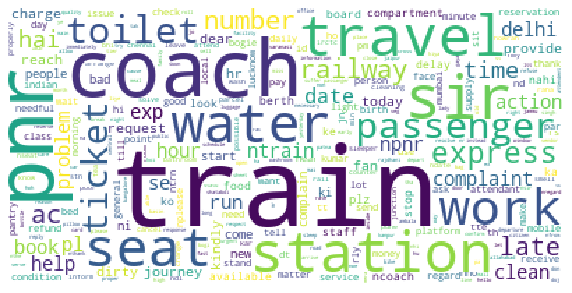

In [16]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordclouds)
plt.axis("off")
plt.show()

In [17]:
df['word_count'] = df['Text'].apply(word_count)
avg_wc = df.groupby('Complaint').mean().reset_index()
avg_wc[['Complaint','word_count']]

NameError: name 'word_count' is not defined

In [18]:
df['complaint_id']=df['Complaint'].factorize()[0]
complaint_id_if=df[['Text','Complaint','Sub_Complaint','complaint_id']].sort_values('complaint_id')

In [19]:
#top 20 words by category 
top_n=20
bigrams1=bigram_freq(cl_text_list,100)
bigrams1

,0,1
0,train_number,8413
1,dear_sir,8248
2,travel_train,4911
3,coach_seat,4591
4,ac_work,4213
5,train_run,4161
6,pnr_ntrn,4000
7,fan_work,3908
8,water_toilet,3811
9,railway_station,3648


In [20]:
wordclouds2=WordCloud(stopwords=stopwords,background_color="white",max_words=1000,collocations = False).generate(" ".join(bigrams1[0]))

In [21]:
data_dict=bigrams1.set_index(0).to_dict()

In [22]:
#data_dict[1]

In [23]:
wordclouds2.generate_from_frequencies(data_dict[1])

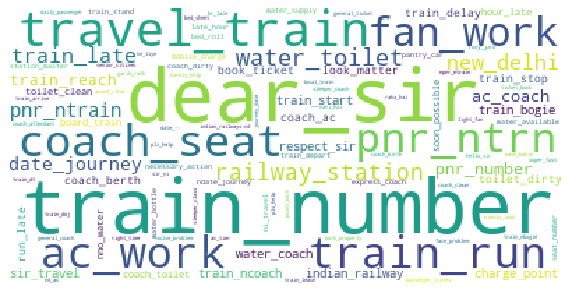

In [24]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordclouds2)
plt.axis("off")
plt.savefig('bigram1.jpeg')
plt.show()


In [26]:
#Top 20 most frequent words for all the articles
def reverse_str(text):
    return str(text).split(' ')
df['clean_list']=df['clean_text'].apply(reverse_str)
cl_text_list = df['clean_list'].tolist()
wf = word_freq(cl_text_list, 100)
wf.head(20)



,0,1
0,train,155738
1,pnr,67474
2,coach,64497
3,sir,36647
4,travel,31686
5,station,31171
6,water,28212
7,seat,27357
8,work,23736
9,passenger,22966


In [27]:
stopwords=STOPWORDS
wordclouds=WordCloud(stopwords=stopwords,background_color="white",max_words=1000,collocations = False).generate(cl_text_str)

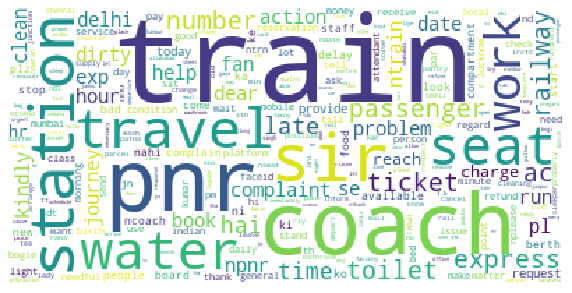

In [28]:
rcParams['figure.figsize'] = 10, 20
plt.imshow(wordclouds)
plt.axis("off")
plt.show()

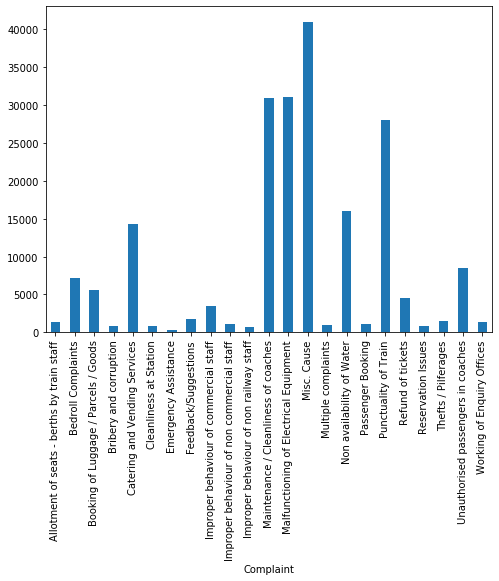

In [29]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(8,6))
df.groupby('Complaint').Text.count().plot.bar(ylim=0)
plt.savefig('Bar.jpeg')

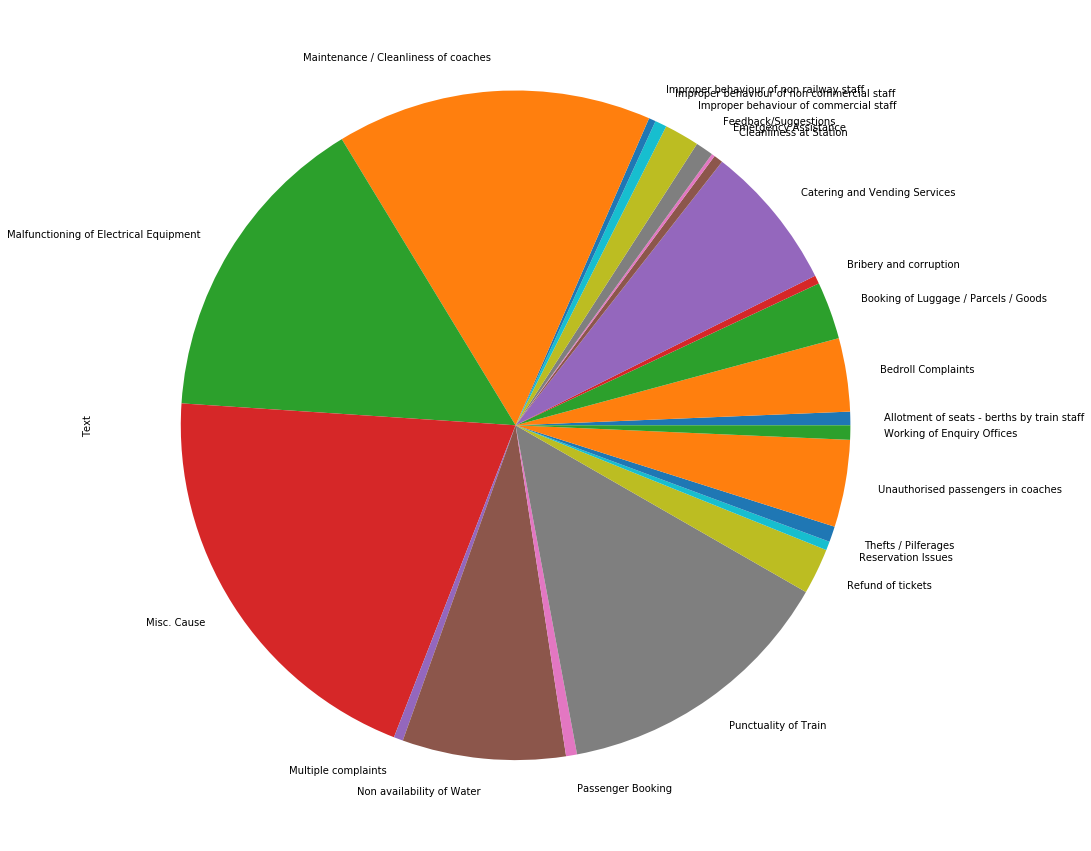

In [30]:
import matplotlib.pyplot as plt
fig=plt.figure(figsize=(15,17))
df.groupby('Complaint').Text.count().plot.pie()
plt.savefig('pie.jpeg')

In [31]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(ngram_range=(1,2),min_df=2,max_df=0.95)
X=tfidf.fit_transform(df['clean_text'].astype('str'))

In [32]:
y=df['complaint_id']
print(X.shape,y.shape)

(203459, 396587) (203459,)


In [33]:

'''Features'''
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import label_binarize

In [34]:
#dimensionality reduction of 100 features
lsa=TruncatedSVD(n_components=100,n_iter=10,random_state=3)
X=lsa.fit_transform(X)
X.shape

(203459, 100)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

In [36]:

'''Classifiers'''
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.multiclass import OneVsRestClassifier

'''Metrics/Evaluation'''
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix
from scipy import interp
from itertools import cycle

'''Plotting'''
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [37]:
#preliminary model evaluation using default parameter
#creating dict of models

model_dict={#'Dummy' : DummyClassifier(random_state=3),
             #'Stochastic Gradient Descent' : SGDClassifier(random_state=3, loss='log'),
              'Random Forest': RandomForestClassifier(random_state=3),
              'Decsision Tree': DecisionTreeClassifier(random_state=3),
              #'AdaBoost': AdaBoostClassifier(random_state=3),
              #'Gaussian Naive Bayes': GaussianNB(),
              #'K Nearest Neighbor': KNeighborsClassifier()
          }

In [38]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,shuffle=True,stratify=y,random_state=3)

In [39]:
clf=model_dict['Random Forest'].fit(X_train,y_train)

/home/anubhav/.local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [40]:
y_pred=model_dict['Random Forest'].predict(X_test)

In [41]:
accuracy_score(y_test,y_pred)*100

63.56368164094498

In [43]:
import pickle

In [46]:
with open('text_classifier', 'wb') as picklefile:  
    pickle.dump(clf,picklefile)

In [55]:
conf_mat=(confusion_matrix(y_test,y_pred)) 

In [47]:
with open('text_classifier', 'rb') as training_model:  
    model = pickle.load(training_model)

In [52]:
y_pred2 = model.predict(X_test)

In [53]:


from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(classification_report(y_test, y_pred2)) 

              precision    recall  f1-score   support

           0       0.72      0.57      0.63      2160
           1       0.47      0.54      0.50     12284
           2       0.24      0.06      0.09       423
           3       0.52      0.68      0.59      9287
           4       0.79      0.69      0.74      4305
           5       0.28      0.11      0.16      1029
           6       0.90      0.89      0.89      1693
           7       0.82      0.81      0.82      8400
           8       0.77      0.69      0.73      4810
           9       0.65      0.35      0.46       274
          10       0.73      0.78      0.75      9320
          11       0.35      0.19      0.25       526
          12       0.25      0.09      0.13       323
          13       0.21      0.07      0.10       258
          14       0.60      0.43      0.50      2566
          15       0.32      0.11      0.17       247
          16       0.76      0.40      0.53       461
          17       0.36    

In [101]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (40,30), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig('con_mat.jpeg')
    return fig

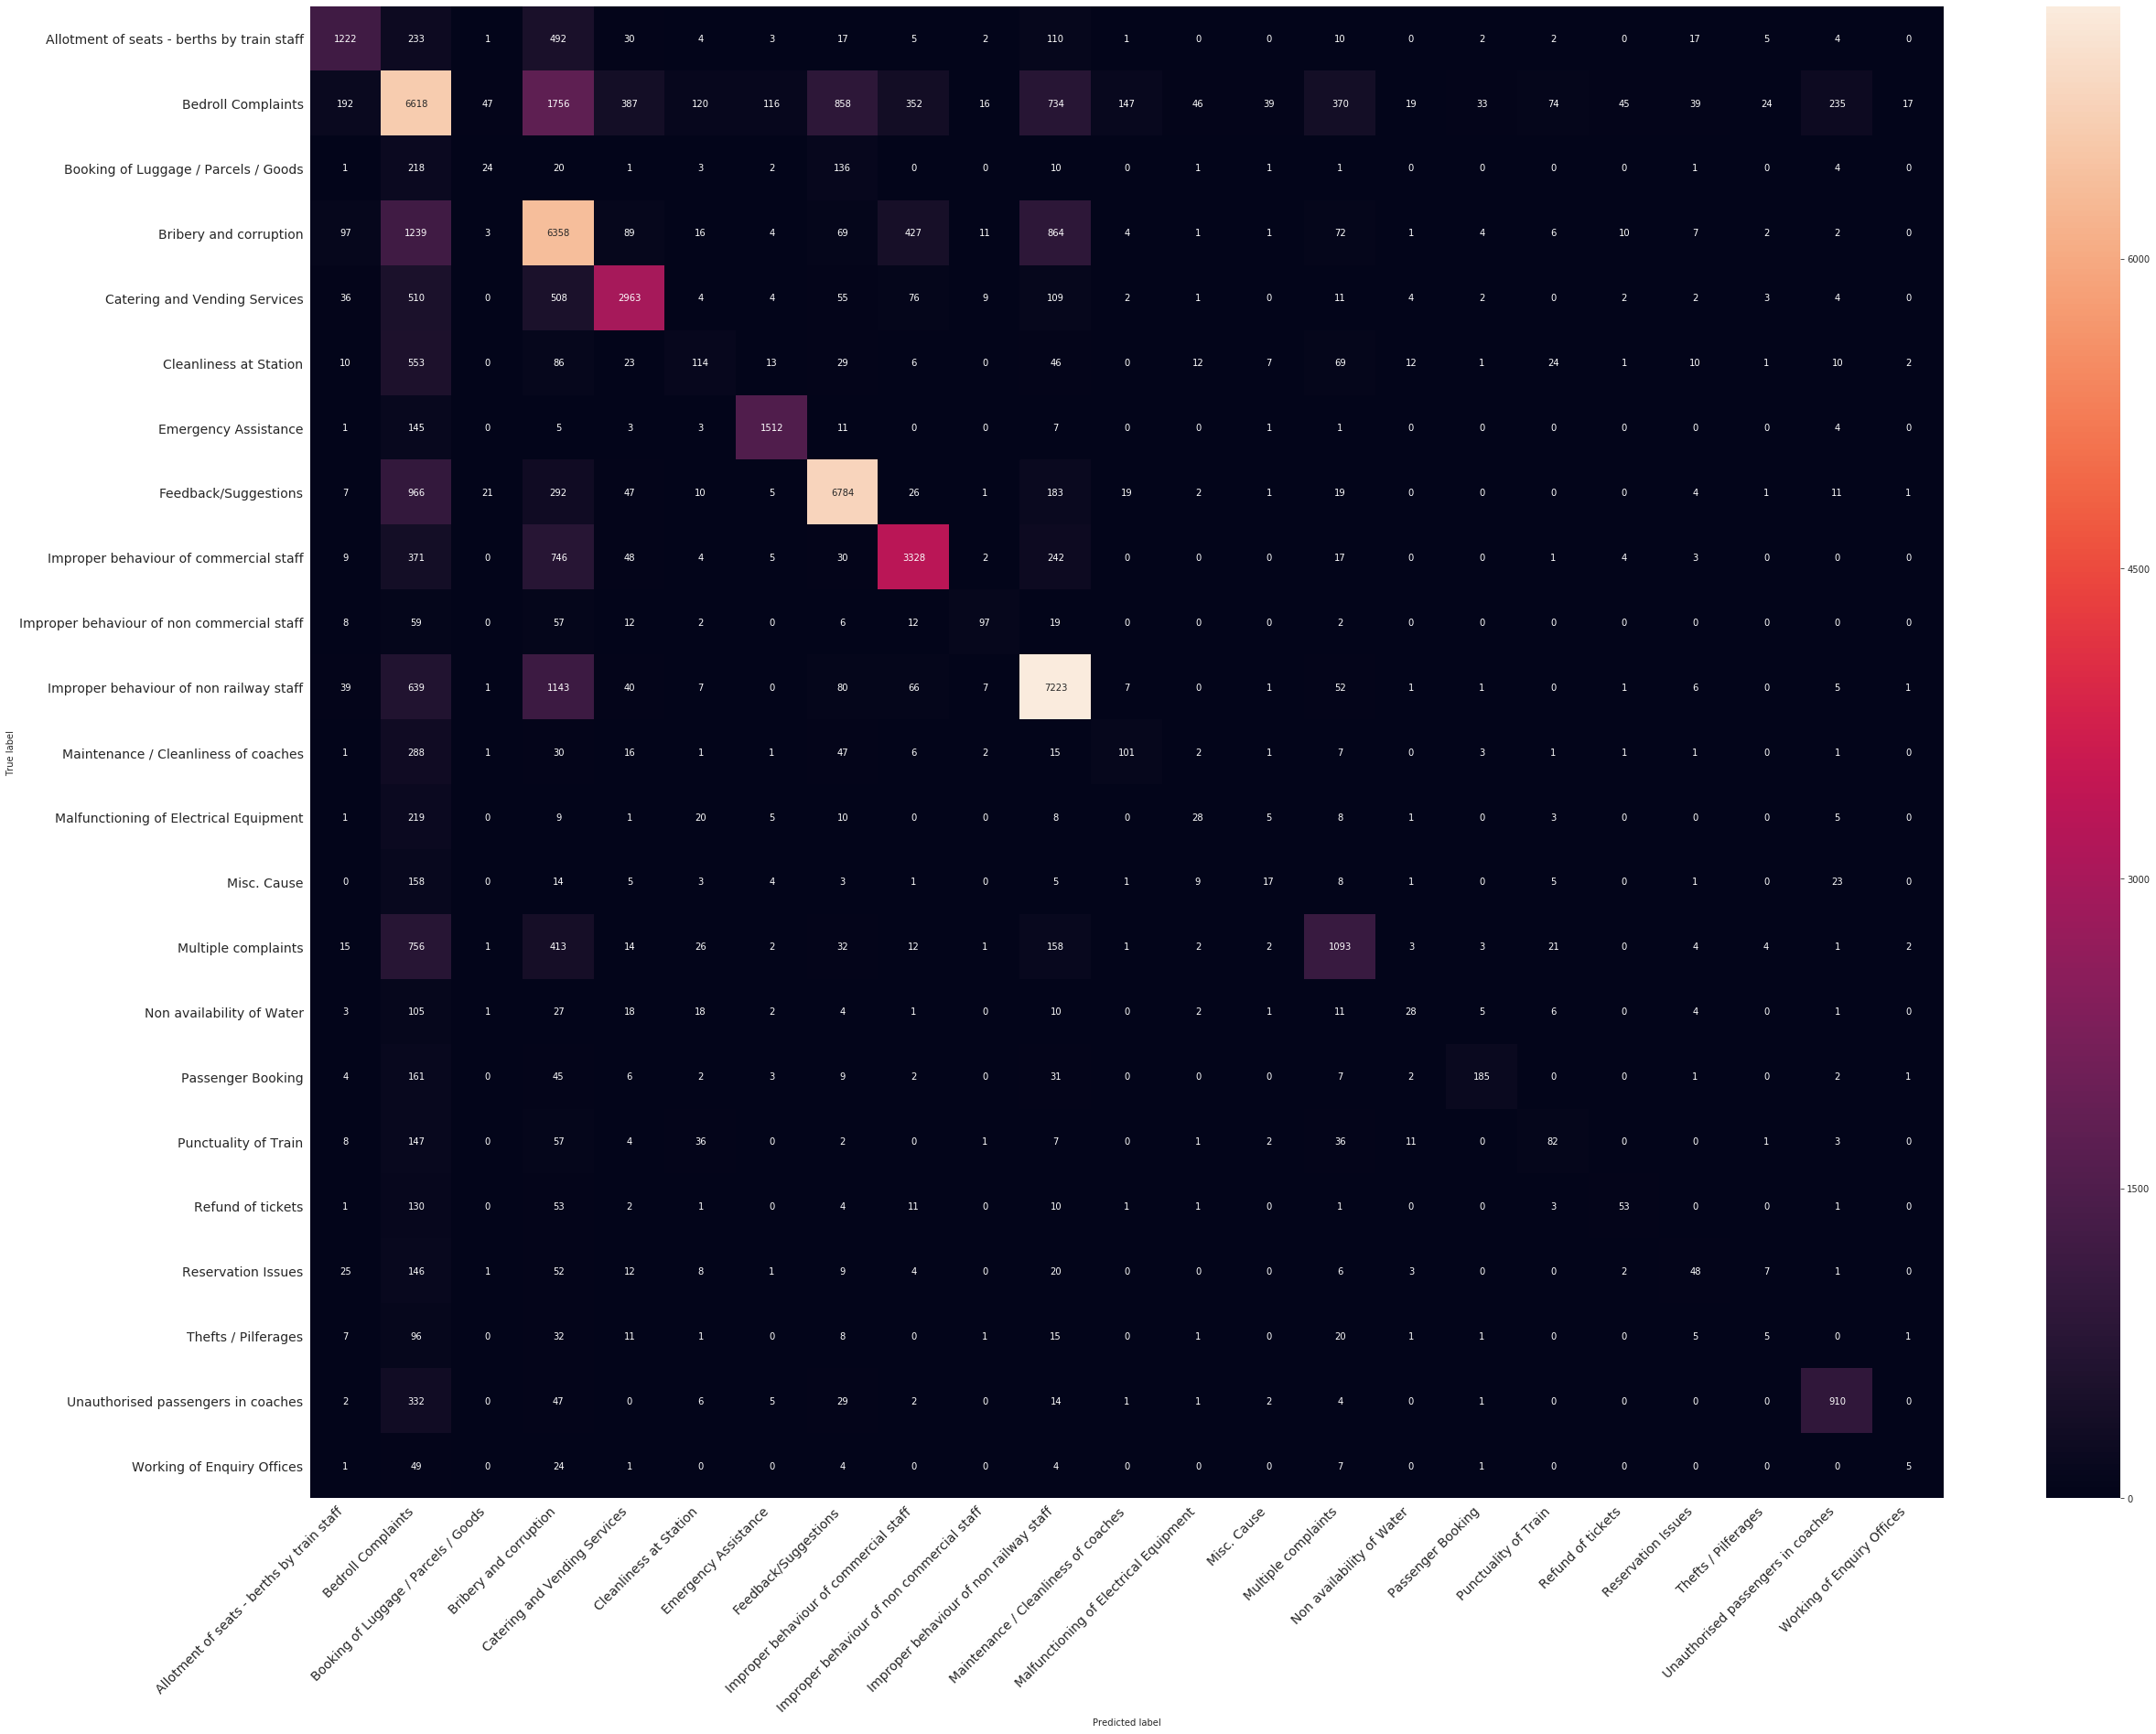

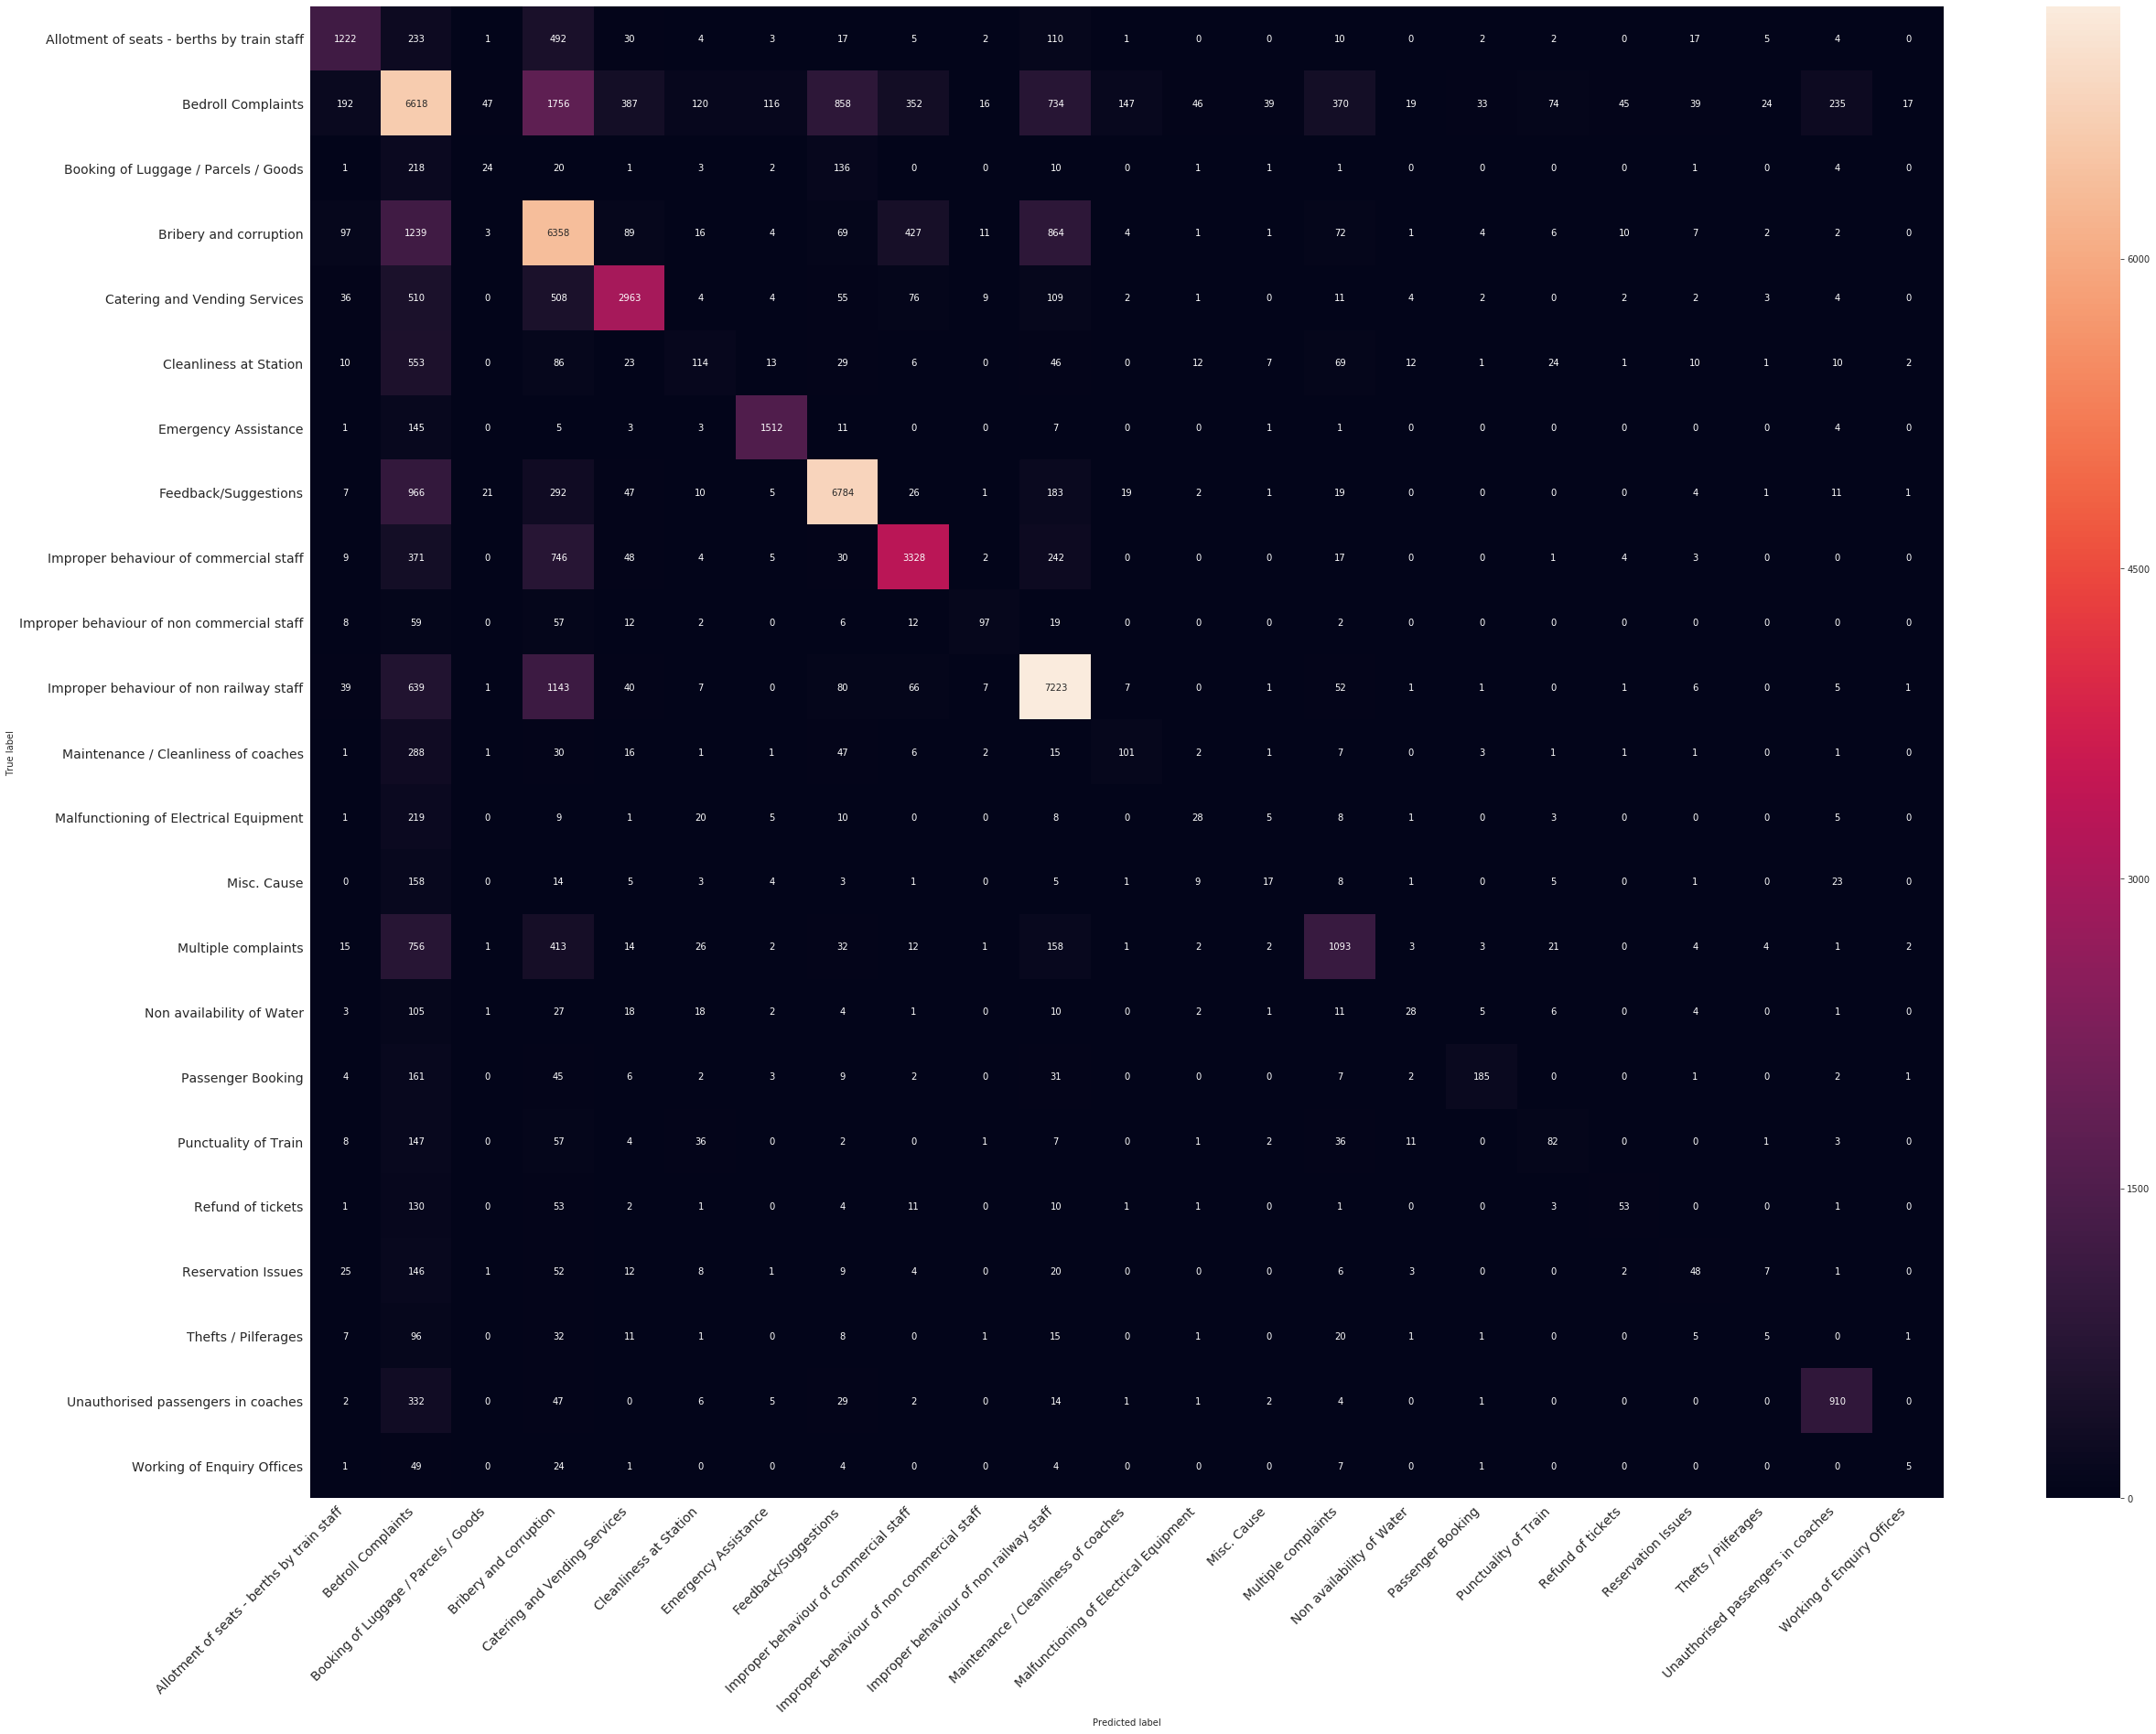

In [102]:
arr=df.Complaint.values
un_arr=np.unique(arr)
print_confusion_matrix(conf_mat,list(un_arr))


(23,)

In [ ]:
from sklearn.metrics import confusion_matrix
conf_mat=confusion_matrix(y_test,y_pred)
fig,ax=plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat,annot=True,fmt='d',xticklabels=df.complaint_id.values,yticklabels=df.complaint_id.values)

In [18]:
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

NameError: name 'plt' is not defined